<a href="https://www.kaggle.com/code/sharanharsoor/responsible-ai-fairness-in-models?scriptVersionId=140591733" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Detect and Mitigate Unfairness in Models
Machine learning models can incorporate unintentional bias, which can lead to issues with fairness. For example, a model that predicts the likelihood of customer churn might work well for some age groups, but not for others.

In this notebook, you'll use the Fairlearn package to analyze a model and explore disparity in prediction performance for Bank customer churn based on age and gender.

In [1]:
! pip install fairlearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.5/231.5 kB 7.4 MB/s eta 0:00:00


# About Dataset

> **RowNumber**—corresponds to the record (row) number and has no effect on the output.

> **CustomerId**—contains random values and has no effect on customer leaving the bank.

> **Surname**—the surname of a customer has no impact on their decision to leave the bank.

> **CreditScore**—can have an effect on customer churn, since a customer with a higher credit score is less likely to leave the bank.

> **Geography**—a customer’s location can affect their decision to leave the bank.

> **Gender**—it’s interesting to explore whether gender plays a role in a customer leaving the bank.

> **Age**—this is certainly relevant, since older customers are less likely to leave their bank than younger ones.

> **Tenure**—refers to the number of years that the customer has been a client of the bank. Normally, older clients are more loyal and less likely to leave a bank.

> **Balance**—also a very good indicator of customer churn, as people with a higher balance in their accounts are less likely to leave the bank compared to those with lower balances.

> **NumOfProducts**—refers to the number of products that a customer has purchased through the bank.

> **HasCrCard**—denotes whether or not a customer has a credit card. This column is also relevant, since people with a credit
card are less likely to leave the bank.

> **IsActiveMember**—active customers are less likely to leave the bank.

> **EstimatedSalary**—as with balance, people with lower salaries are more likely to leave the bank compared to those with higher salaries.

> **Exited**—whether or not the customer left the bank.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [4]:
df = pd.read_csv('/kaggle/input/bank-customers-and-their-churn-behavior/churn.csv')
df.Exited.value_counts() #from count we can say that dataset is imbalanced

0    7963
1    2037
Name: Exited, dtype: int64

From counts of Exited it's clear that data is highly imbalanced and we have resample the data

In [5]:
df.info() # no missing values
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [6]:
#balancing the imbalaced datasets
Exited_records = df['Exited'].sum()
Exited_indices = np.array(df[df.Exited == 1].index)

# Picking the indices of the normal Exited
normal_indices = df[df.Exited == 0].index

# Out of the indices we picked, randomly select number of normal records = number of Exited records
random_normal_indices = np.random.choice(normal_indices, Exited_records, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Merge the 2 indices
under_sample_indices = np.concatenate([Exited_indices,random_normal_indices])

# Copy under sample dataset
under_sample_data = df.iloc[under_sample_indices,:]

# Split data into features and target labels
features_undersample = under_sample_data.drop(['Exited'], axis = 1)
target_undersample = under_sample_data['Exited']

# Show ratio
print("Percentage of NotExited: ", under_sample_data.Exited[under_sample_data['Exited'] == 0].count())
print("Percentage of Exited: ", under_sample_data.Exited[under_sample_data['Exited'] == 1].count())
print("Total number of  resampled data: ", under_sample_data['Exited'].count())

Percentage of NotExited:  2037
Percentage of Exited:  2037
Total number of  resampled data:  4074


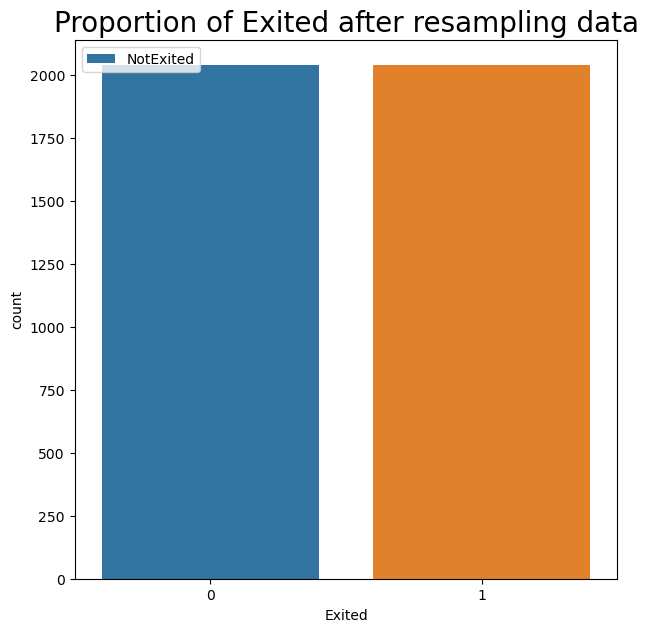

In [7]:
# Plot the proportion
under_sample_Exited_Real = [under_sample_data.Exited[under_sample_data['Exited'] == 0].count(), Exited_records]
plt.subplots(figsize = (7, 7))
plt.title("Proportion of Exited after resampling data", size = 20)
ax = sns.countplot(x = under_sample_data['Exited'], data= under_sample_data)
ax.legend(labels=['NotExited', 'Exited'], loc = 'upper left')

In [8]:
# removing unnecessary columns
under_sample_data = under_sample_data.drop(under_sample_data.columns[0:3], axis=1)

In [9]:
# rename columns
mapping = {'HasCrCard':'HasCreditCard'
          }
under_sample_data=under_sample_data.rename(columns=mapping)
under_sample_data

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCreditCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
5,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
7,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
16,653,Germany,Male,58,1,132602.88,1,1,0,5097.67,1
...,...,...,...,...,...,...,...,...,...,...,...
3442,850,Germany,Female,30,8,154870.28,1,1,1,54191.38,0
3680,850,Spain,Male,22,3,0.00,1,1,1,144385.54,0
1984,531,Spain,Female,45,1,126495.57,2,1,1,164741.50,0
2645,755,France,Male,23,5,84284.48,2,1,1,62851.60,0


In [10]:
under_sample_data.isnull().sum() # no missing data

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCreditCard      0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

array([[<Axes: title={'center': 'CreditScore'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Tenure'}>],
       [<Axes: title={'center': 'Balance'}>,
        <Axes: title={'center': 'NumOfProducts'}>,
        <Axes: title={'center': 'HasCreditCard'}>],
       [<Axes: title={'center': 'IsActiveMember'}>,
        <Axes: title={'center': 'EstimatedSalary'}>,
        <Axes: title={'center': 'Exited'}>]], dtype=object)

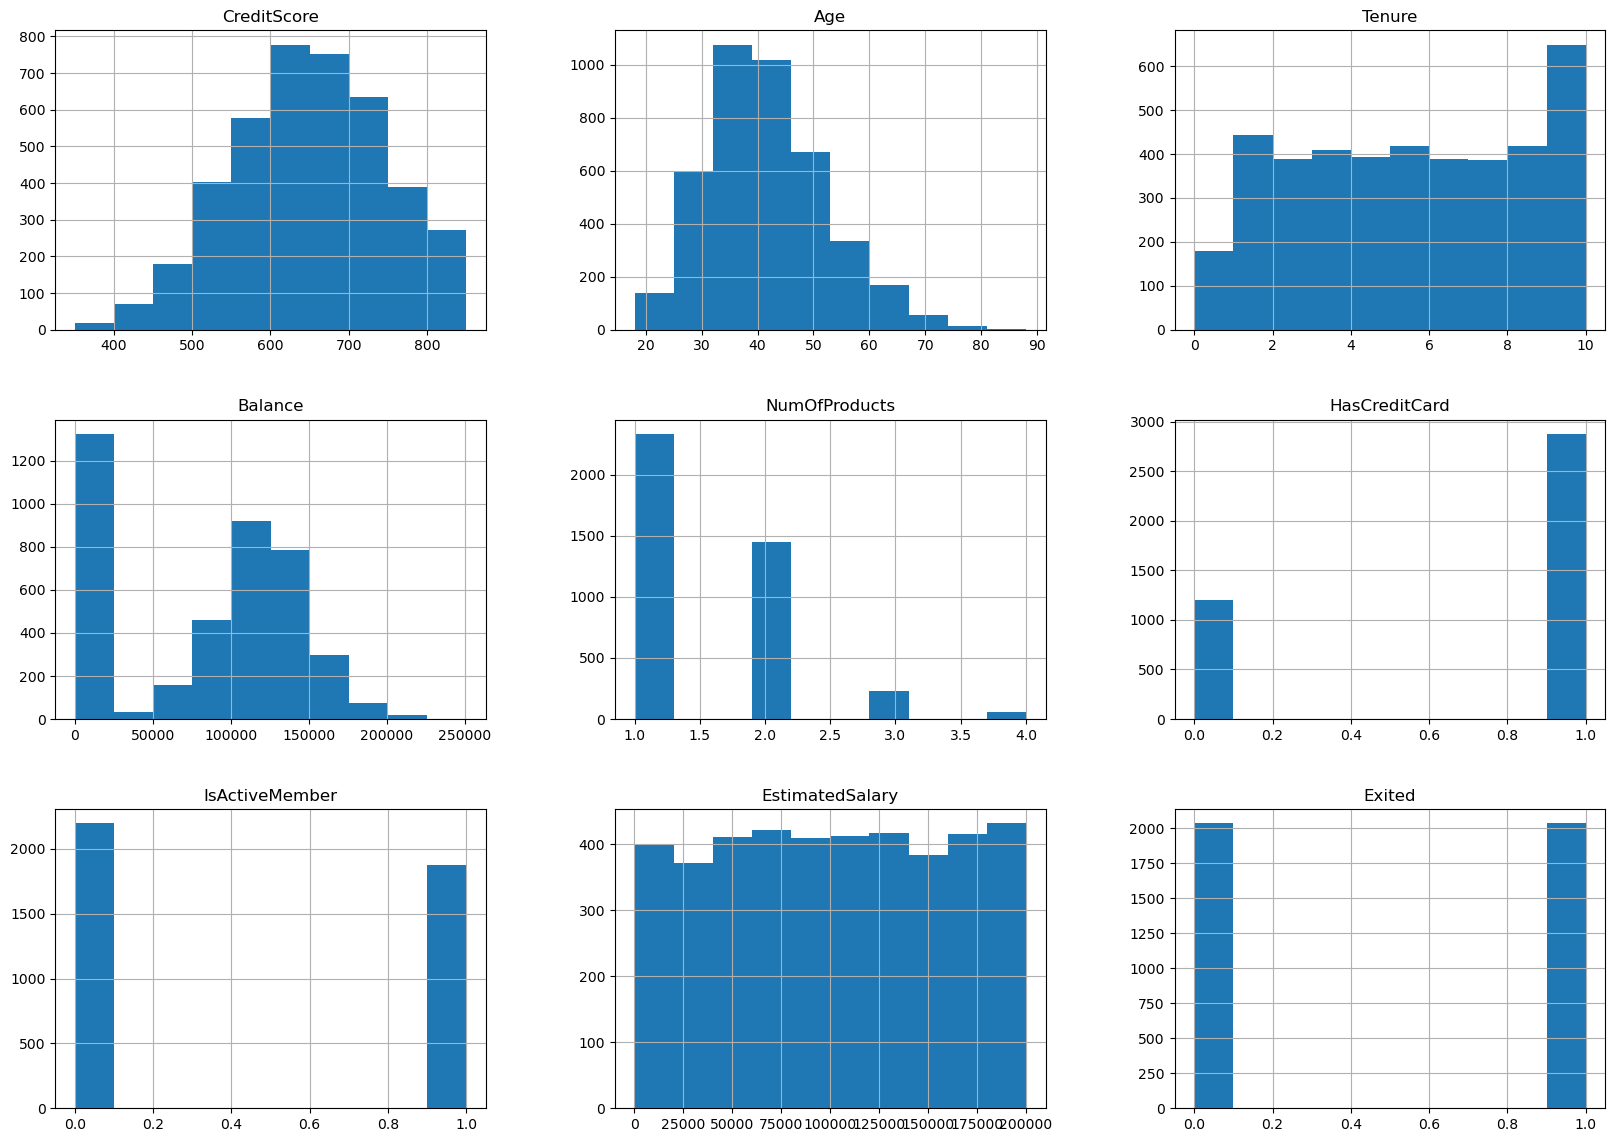

In [11]:
# checking for outliars
under_sample_data.hist(figsize=(20,14)) # no outliers

/tmp/ipykernel_21/1453042177.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(under_sample_data.corr(), cmap='YlGnBu', linewidths = 2, vmin=-1, vmax=1, fmt='.2f', annot=True)


<Axes: >

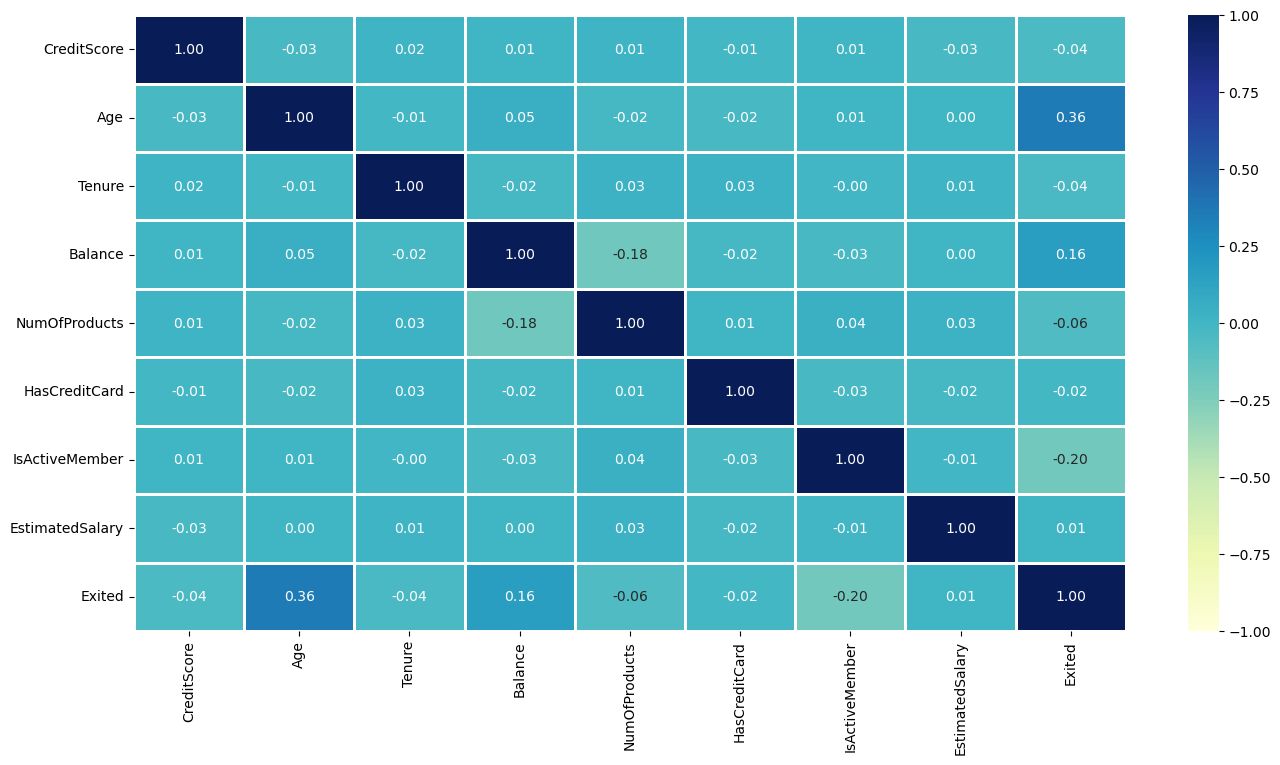

In [12]:
plt.rcParams['figure.figsize'] = (16,8)
sns.heatmap(under_sample_data.corr(), cmap='YlGnBu', linewidths = 2, vmin=-1, vmax=1, fmt='.2f', annot=True)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


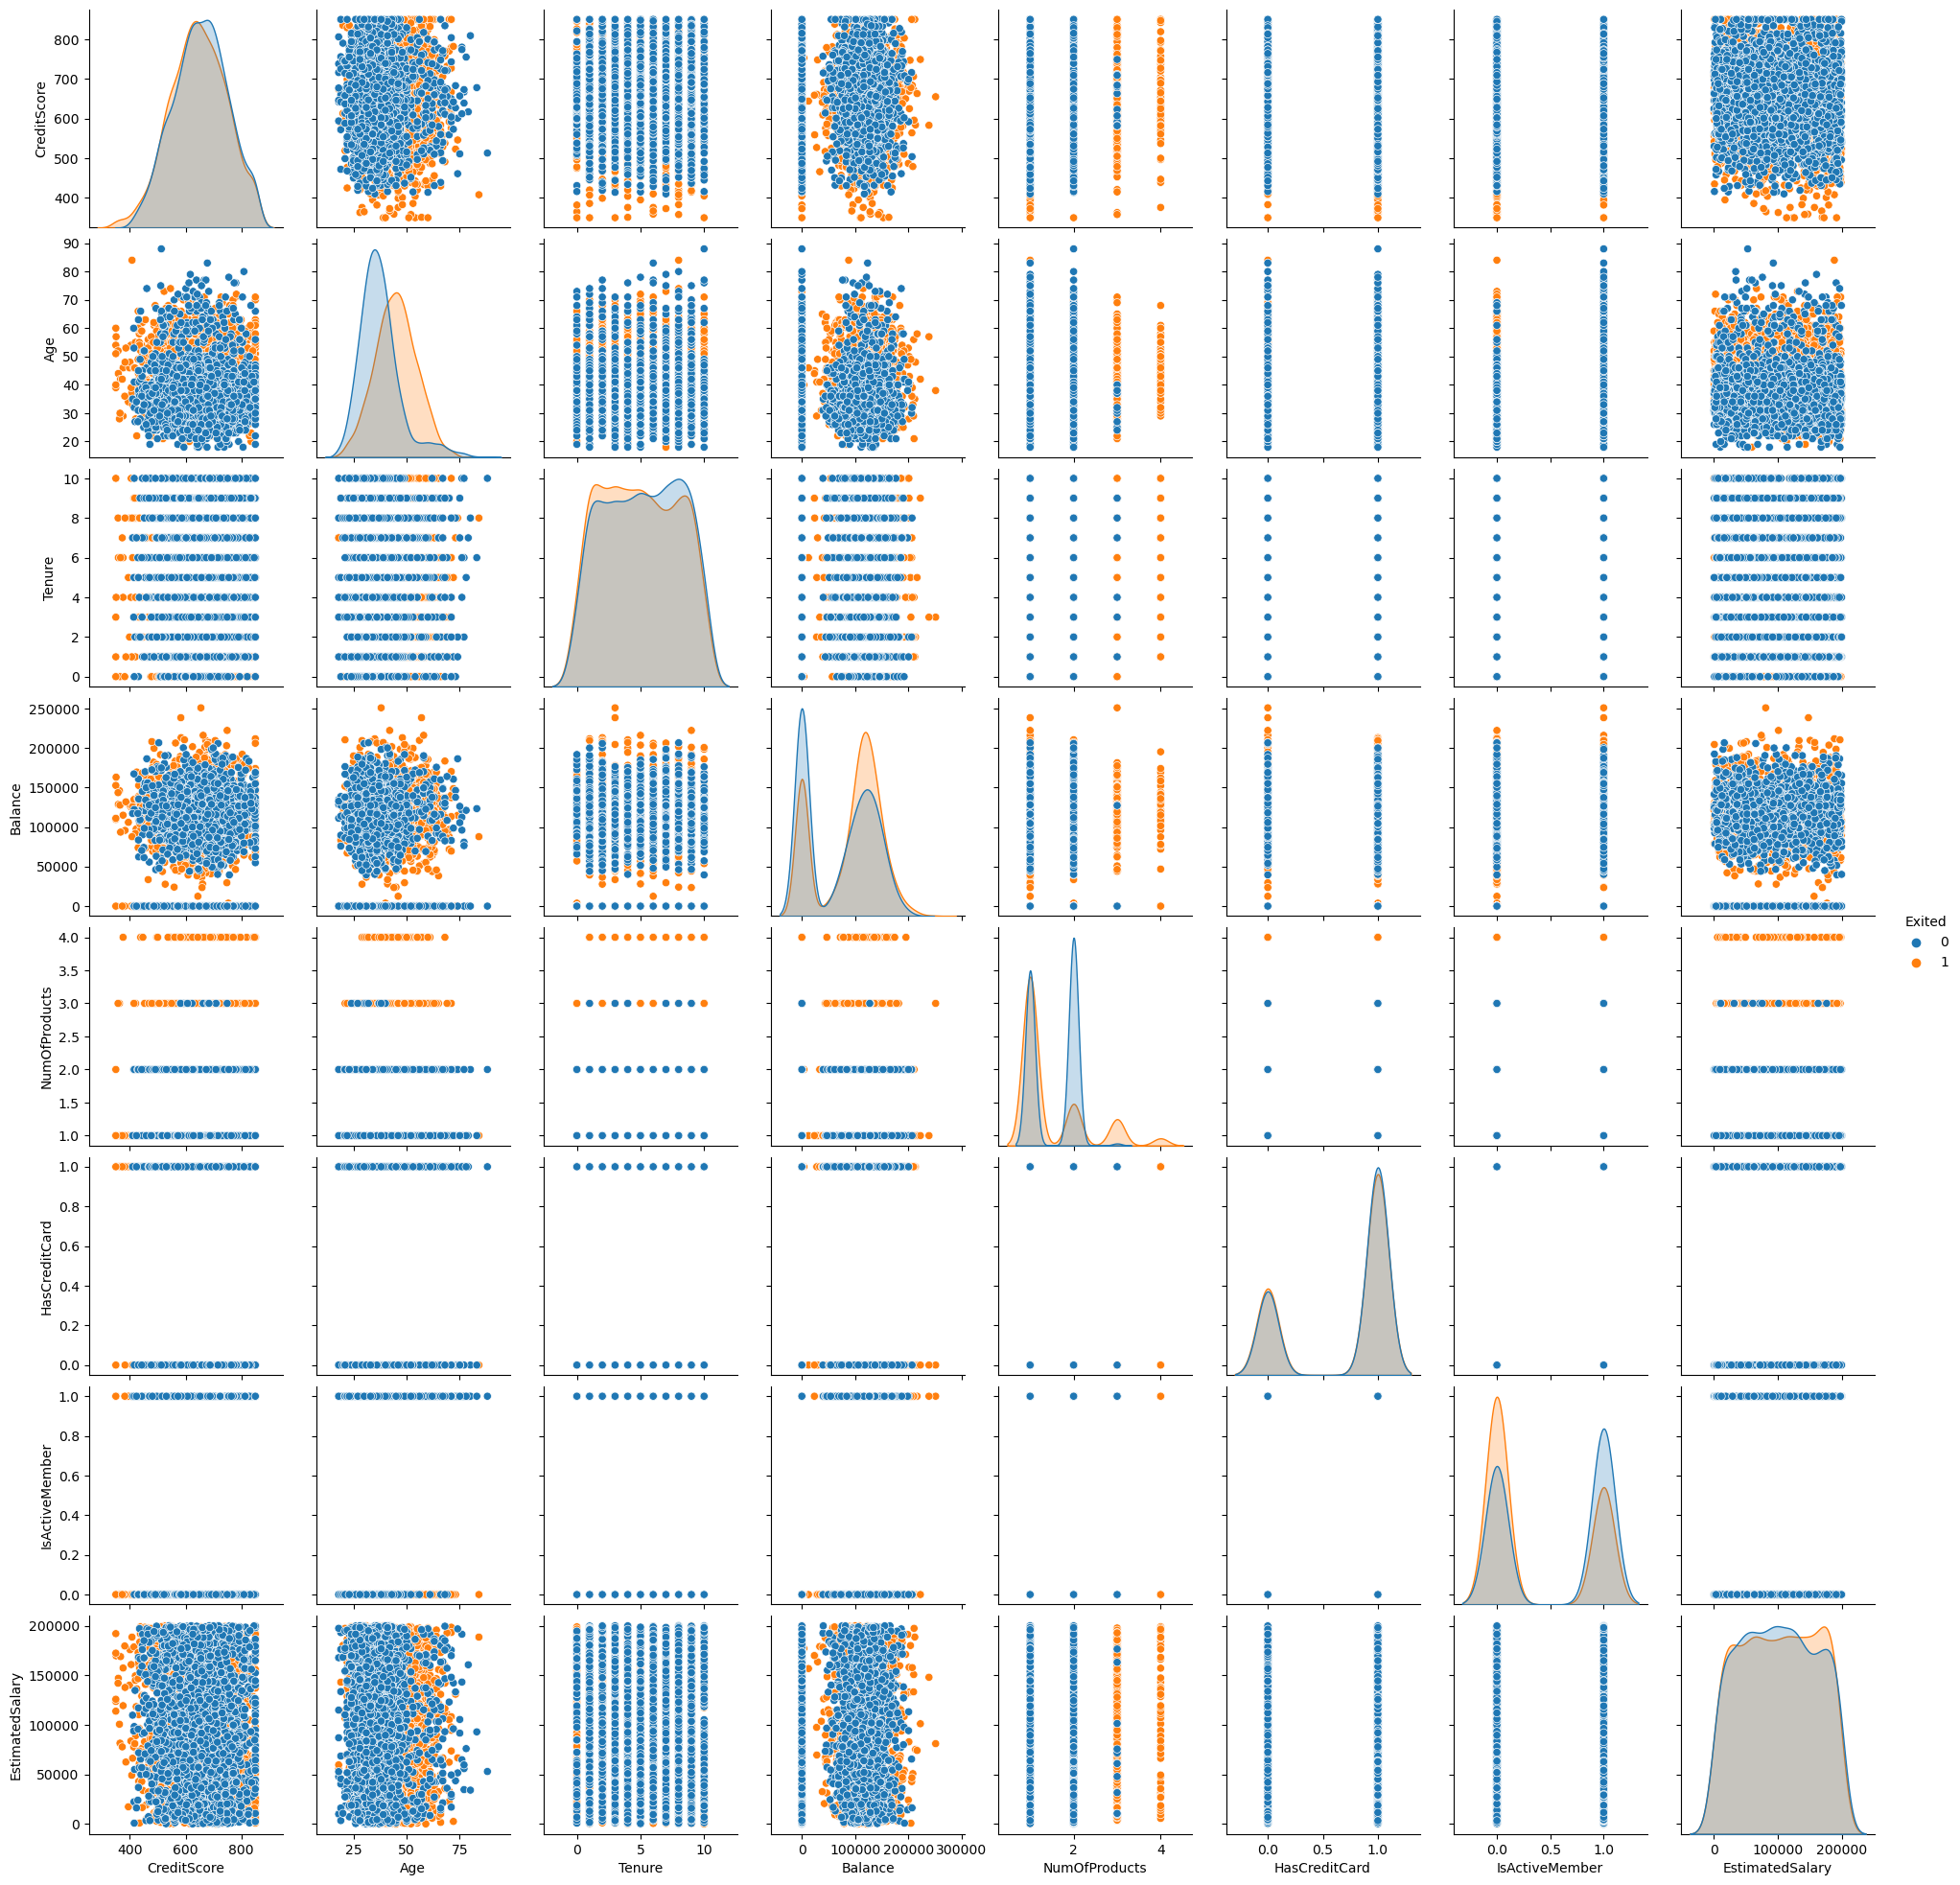

In [13]:
sns.pairplot(under_sample_data,hue = 'Exited')

In [14]:
X = under_sample_data.iloc[:, :-1]
X = pd.get_dummies(X)
X.head()
y = under_sample_data.Exited

In [15]:
s = under_sample_data[['Age']]

In [16]:
# Change value to represent age groups
s['Age'] = np.where(s.Age > 40,'Over 40', '40 or younger')
s['Age'].value_counts()

/tmp/ipykernel_21/2394216179.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  s['Age'] = np.where(s.Age > 40,'Over 40', '40 or younger')


40 or younger    2143
Over 40          1931
Name: Age, dtype: int64

In [17]:
G = under_sample_data[['Gender']]
# # Change value to represent age groups
G['Gender'] = np.where(G.Gender == 'Female',0,1)
G['Gender'].value_counts()

/tmp/ipykernel_21/2809652423.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  G['Gender'] = np.where(G.Gender == 'Female',0,1)


1    2119
0    1955
Name: Gender, dtype: int64

In [18]:
#improting necassery libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier as DecisionTree
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score,accuracy_score

In [19]:
X_train, X_test, y_train, y_test,S_train,S_test,G_train,G_test = train_test_split(X, y,s, G, test_size=0.2, random_state=0, stratify=y)

churn_model = DecisionTreeClassifier(max_depth=50, min_samples_split=50, min_samples_leaf=25,
                                  max_leaf_nodes=100, class_weight='balanced', ccp_alpha=0.0001).fit(X_train, y_train)

# Gerneric model (no sensitivity)

In [20]:
from fairlearn.metrics import selection_rate, MetricFrame
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Get predictions for the witheld test data
y_hat = churn_model.predict(X_test)

# Get overall metrics
print("Overall Metrics:")
# Get selection rate from fairlearn
overall_selection_rate = selection_rate(y_test, y_hat) # Get selection rate from fairlearn
print("\tSelection Rate:", overall_selection_rate)
# Get standard metrics from scikit-learn
overall_accuracy = accuracy_score(y_test, y_hat)
print("\tAccuracy:", overall_accuracy)
overall_recall = recall_score(y_test, y_hat)
print("\tRecall:", overall_recall)
overall_precision = precision_score(y_test, y_hat)
print("\tPrecision:", overall_precision)

# Get metrics by sensitive group from fairlearn
print('\nMetrics by Group:')
metrics = {'selection_rate': selection_rate,
           'accuracy': accuracy_score,
           'recall': recall_score,
           'precision': precision_score}

group_metrics = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_hat,
                             sensitive_features=S_test)

group_metrics1 = MetricFrame(metrics=metrics,
                             y_true=y_test,
                             y_pred=y_hat,
                             sensitive_features=G_test)

print(group_metrics.by_group)
print(group_metrics1.by_group)

Overall Metrics:
	Selection Rate: 0.452760736196319
	Accuracy: 0.7791411042944786
	Recall: 0.7321867321867321
	Precision: 0.8075880758807588

Metrics by Group:
               selection_rate  accuracy    recall  precision
Age                                                         
40 or younger        0.222738  0.756381  0.465116   0.625000
Over 40              0.710938  0.804688  0.856115   0.871795
        selection_rate  accuracy    recall  precision
Gender                                               
0             0.506812  0.749319  0.709821   0.854839
1             0.408482  0.803571  0.759563   0.759563


## Note: Unfortunately, I'm unable to install raiwidgets in the Kaggle environment, which is why I can't generate the FairnessDashboard. Trying this on a local setup would be a viable solution.

In [21]:
'''
from raiwidgets import FairnessDashboard

# View this model in Fairlearn's fairness dashboard, and see the disparities which appear:
FairnessDashboard(sensitive_features=S_test,y_true=y_test,y_pred={"churn_model": churn_model.predict(X_test)})
FairnessDashboard(sensitive_features=G_test,y_true=y_test,y_pred={"churn_model": churn_model.predict(X_test)})
'''

'\nfrom raiwidgets import FairnessDashboard\n\n# View this model in Fairlearn\'s fairness dashboard, and see the disparities which appear:\nFairnessDashboard(sensitive_features=S_test,y_true=y_test,y_pred={"churn_model": churn_model.predict(X_test)})\nFairnessDashboard(sensitive_features=G_test,y_true=y_test,y_pred={"churn_model": churn_model.predict(X_test)})\n'

# analysis based on Age sensitivity feature.

In [22]:
from fairlearn.reductions import GridSearch,  DemographicParity
import joblib
import os

print('Finding mitigated models...')

# Train multiple models
sweep =GridSearch(DecisionTreeClassifier(max_depth=50, min_samples_split=50, min_samples_leaf=25,
                                  max_leaf_nodes=100, class_weight='balanced', ccp_alpha=0.0001),
                   constraints=DemographicParity(), # note the constraint on DemographicParity.
                   grid_size=50)

sweep.fit(X_train, y_train, sensitive_features= S_train)  # passing sensitive_features parameter for sensitivity.
models = sweep.predictors_

# Save the models and get predictions from them (plus the original unmitigated one for comparison)
model_dir = 'mitigated_models'
os.makedirs(model_dir, exist_ok=True)
model_name = 'Churn_unmitigated'
print(model_name)
joblib.dump(value=churn_model, filename=os.path.join(model_dir, '{0}.pkl'.format(model_name)))
predictions = {model_name: churn_model.predict(X_test)}
i = 0
for model in models:
    i += 1
    model_name = 'Churn_mitigated_{0}'.format(i)
    print(model_name)
    joblib.dump(value=model, filename=os.path.join(model_dir, '{0}.pkl'.format(model_name)))
    predictions[model_name] = model.predict(X_test)


Finding mitigated models...
Churn_unmitigated
Churn_mitigated_1
Churn_mitigated_2
Churn_mitigated_3
Churn_mitigated_4
Churn_mitigated_5
Churn_mitigated_6
Churn_mitigated_7
Churn_mitigated_8
Churn_mitigated_9
Churn_mitigated_10
Churn_mitigated_11
Churn_mitigated_12
Churn_mitigated_13
Churn_mitigated_14
Churn_mitigated_15
Churn_mitigated_16
Churn_mitigated_17
Churn_mitigated_18
Churn_mitigated_19
Churn_mitigated_20
Churn_mitigated_21
Churn_mitigated_22
Churn_mitigated_23
Churn_mitigated_24
Churn_mitigated_25
Churn_mitigated_26
Churn_mitigated_27
Churn_mitigated_28
Churn_mitigated_29
Churn_mitigated_30
Churn_mitigated_31
Churn_mitigated_32
Churn_mitigated_33
Churn_mitigated_34
Churn_mitigated_35
Churn_mitigated_36
Churn_mitigated_37
Churn_mitigated_38
Churn_mitigated_39
Churn_mitigated_40
Churn_mitigated_41
Churn_mitigated_42
Churn_mitigated_43
Churn_mitigated_44
Churn_mitigated_45
Churn_mitigated_46
Churn_mitigated_47
Churn_mitigated_48
Churn_mitigated_49
Churn_mitigated_50


In [23]:
'''
FairnessDashboard(sensitive_features=S_test,
                   y_true=y_test,
                   y_pred=predictions)
'''

'\nFairnessDashboard(sensitive_features=S_test,\n                   y_true=y_test,\n                   y_pred=predictions)\n'

# analysis based on Gender sensitivity feature.

In [24]:
from fairlearn.reductions import GridSearch,  DemographicParity
import joblib
import os

print('Finding mitigated models...')

# Train multiple models
sweep =GridSearch(DecisionTreeClassifier(max_depth=50, min_samples_split=50, min_samples_leaf=25,
                                  max_leaf_nodes=100, class_weight='balanced', ccp_alpha=0.0001),
                   constraints=DemographicParity(),
                   grid_size=50)

sweep.fit(X_train, y_train, sensitive_features=G_train)
models = sweep.predictors_

# Save the models and get predictions from them (plus the original unmitigated one for comparison)
model_dir = 'Gender_mitigated_models'
os.makedirs(model_dir, exist_ok=True)
model_name = 'Gender_Churn_unmitigated'
print(model_name)
joblib.dump(value=churn_model, filename=os.path.join(model_dir, '{0}.pkl'.format(model_name)))
predictions = {model_name: churn_model.predict(X_test)}
i = 0
for model in models:
    i += 1
    model_name = 'Gender_Churn_unmitigated{0}'.format(i)
    print(model_name)
    joblib.dump(value=model, filename=os.path.join(model_dir, '{0}.pkl'.format(model_name)))
    predictions[model_name] = model.predict(X_test)


Finding mitigated models...
Gender_Churn_unmitigated
Gender_Churn_unmitigated1
Gender_Churn_unmitigated2
Gender_Churn_unmitigated3
Gender_Churn_unmitigated4
Gender_Churn_unmitigated5
Gender_Churn_unmitigated6
Gender_Churn_unmitigated7
Gender_Churn_unmitigated8
Gender_Churn_unmitigated9
Gender_Churn_unmitigated10
Gender_Churn_unmitigated11
Gender_Churn_unmitigated12
Gender_Churn_unmitigated13
Gender_Churn_unmitigated14
Gender_Churn_unmitigated15
Gender_Churn_unmitigated16
Gender_Churn_unmitigated17
Gender_Churn_unmitigated18
Gender_Churn_unmitigated19
Gender_Churn_unmitigated20
Gender_Churn_unmitigated21
Gender_Churn_unmitigated22
Gender_Churn_unmitigated23
Gender_Churn_unmitigated24
Gender_Churn_unmitigated25
Gender_Churn_unmitigated26
Gender_Churn_unmitigated27
Gender_Churn_unmitigated28
Gender_Churn_unmitigated29
Gender_Churn_unmitigated30
Gender_Churn_unmitigated31
Gender_Churn_unmitigated32
Gender_Churn_unmitigated33
Gender_Churn_unmitigated34
Gender_Churn_unmitigated35
Gender_Chur

In [25]:
'''
FairnessDashboard(sensitive_features=G_test,
                   y_true=y_test,
                   y_pred=predictions)
'''

'\nFairnessDashboard(sensitive_features=G_test,\n                   y_true=y_test,\n                   y_pred=predictions)\n'

### -------------------------------------------- Happy Learning  --------------------------------------------#